In [0]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import random as rand
from string import punctuation
from collections import Counter
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn

In [0]:
# read data
data = pd.read_csv("https://raw.githubusercontent.com/AyeEyeTwoFive/IMDB/master/IMDB%20Dataset.csv")
reviews = data.iloc[:,0]
labels = data.iloc[:,2]
reviews = reviews.tolist()
labels = labels.tolist()
reviews = '\n'.join(reviews)
# Convert labels to ints
labels = [1 if label =='positive' else 0 for label in labels]
labels = np.array(labels)

Number of reviews : 50000
Counter({'the': 663815, 'and': 320663, 'a': 320517, 'of': 288382, 'to': 266773, 'is': 210161, 'in': 184861, 'it': 152899, 'i': 152092, 'this': 149405, 'that': 136092, 'br': 113794, 'was': 95223, 'as': 91231, 'with': 86846, 'for': 86726, 'movie': 83510, 'but': 81766, 'film': 74453, 'on': 66663, 'not': 59869, 'you': 59561, 'are': 58177, 'his': 57279, 'have': 55054, 'be': 52737, 'he': 51943, 'one': 51024, 'its': 49017, 'at': 46498, 'all': 45249, 'by': 44142, 'an': 42822, 'they': 41534, 'from': 40288, 'who': 40179, 'so': 39507, 'like': 38989, 'or': 34952, 'just': 34866, 'her': 34246, 'about': 33886, 'if': 33585, 'has': 32894, 'out': 32710, 'some': 30993, 'there': 30568, 'what': 30285, 'good': 28569, 'when': 27878, 'more': 27675, 'very': 27593, 'my': 24763, 'even': 24572, 'no': 24418, 'up': 24225, 'would': 24024, 'she': 23884, 'time': 23257, 'only': 23078, 'which': 23046, 'really': 22948, 'their': 22693, 'see': 22534, 'were': 22199, 'story': 22090, 'had': 21985, 'c

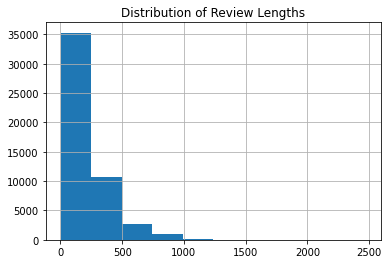

In [4]:
# Process Data
reviews = reviews.lower() # convert to lower case
allrev = ''.join([c for c in reviews if c not in punctuation]) # remove punctuation
revsplit = allrev.split('\n')
print ('Number of reviews :', len(revsplit))
allrev2 = ' '.join(revsplit)
words = allrev2.split() # list words
counts = Counter(words) # Count word frequencies
total_words = len(words)
sorted_words = counts.most_common(total_words)
print (counts)
# mapping words to int ordered by frequency
vocab_to_int = {w:i+1 for i, (w,c) in enumerate(sorted_words)} 
# Encode words as ints
revints = []
for review in revsplit:
    r = [vocab_to_int[w] for w in review.split()]
    revints.append(r)
print (revints[0:3])
%matplotlib inline
revslen = [len(x) for x in revints]
pd.Series(revslen).hist()
plt.title('Distribution of Review Lengths')
plt.show()
pd.Series(revslen).describe()

#Remove outlier short or long reviews
revints = [revints[i] for i, l in enumerate(revslen) if l>0 ]
labels = [labels[i] for i, l in enumerate(revslen) if l> 0 ]

# Pad or truncate reviews to achieve consistent length
seq_length=200
features = np.zeros((len(revints), seq_length), dtype = int)
    
for i, review in enumerate(revints):
    review_len = len(review)
    if review_len <= seq_length:
        zeroes = list(np.zeros(seq_length-review_len))
        new = zeroes+review
    elif review_len > seq_length:
        new = review[0:seq_length]
    features[i,:] = np.array(new)

In [0]:
# 80% train, 10% validation, 10% test splits
split_frac = 0.8
len_feat = len(features)
train_x = features[0:int(split_frac*len_feat)]
train_y = labels[0:int(split_frac*len_feat)]
remaining_x = features[int(split_frac*len_feat):]
remaining_y = labels[int(split_frac*len_feat):]
valid_x = remaining_x[0:int(len(remaining_x)*0.5)]
valid_y = remaining_y[0:int(len(remaining_y)*0.5)]
test_x = remaining_x[int(len(remaining_x)*0.5):]
test_y = remaining_y[int(len(remaining_y)*0.5):]

In [0]:
# Data Loading
train_data = TensorDataset(torch.FloatTensor(train_x), torch.FloatTensor(train_y))
valid_data = TensorDataset(torch.FloatTensor(valid_x), torch.FloatTensor(valid_y))
test_data = TensorDataset(torch.FloatTensor(test_x), torch.FloatTensor(test_y))
batch_size = 50
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)

In [0]:
### Define LSTM Model

class ReviewLSTM(nn.Module):

    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.5):
        """
        Initialize the model by setting up the layers.
        """
        super().__init__()

        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        # embedding and LSTM 
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, 
                            dropout=drop_prob, batch_first=True)
        
        # dropout
        self.dropout = nn.Dropout(0.3)
        
        # linear and sigmoid 
        self.fc = nn.Linear(hidden_dim, output_size)
        self.sig = nn.Sigmoid()
        

    def forward(self, x, hidden):
        """
        Perform a forward pass of our model on some input and hidden state.
        """
        batch_size = x.size(0)


        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)
    

        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        
        # fully-connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)
        # sigmoid
        sig_out = self.sig(out)
        
        # reshape
        sig_out = sig_out.view(batch_size, -1)
        sig_out = sig_out[:, -1] # get last batch of labels
        

        return sig_out, hidden
    
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        

        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())
        
        return hidden

In [8]:
# Instantiate and train model
vocab_size = len(vocab_to_int)+1 # +1 for the 0 padding
output_size = 1
embedding_dim = 400
hidden_dim = 256
n_layers = 2
net = ReviewLSTM(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)
print(net)

ReviewLSTM(
  (embedding): Embedding(181686, 400)
  (lstm): LSTM(400, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)


In [9]:
# define loss/opt
lr=0.001

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)


# train params
epochs = 1
counter = 0
print_every = 100
clip=5 


net.train()

for e in range(epochs):

    h = net.init_hidden(batch_size)


    for inputs, labels in train_loader:
        counter += 1

        h = tuple([each.data for each in h])


        net.zero_grad()


        inputs = inputs.type(torch.LongTensor)
        output, h = net(inputs, h)

        loss = criterion(output.squeeze(), labels.float())
        loss.backward()

        nn.utils.clip_grad_norm_(net.parameters(), clip)
        optimizer.step()

        # calc loss
        if counter % print_every == 0:

            val_h = net.init_hidden(batch_size)
            val_losses = []
            net.eval()
            for inputs, labels in valid_loader:


                val_h = tuple([each.data for each in val_h])

                inputs = inputs.type(torch.LongTensor)
                output, val_h = net(inputs, val_h)
                val_loss = criterion(output.squeeze(), labels.float())

                val_losses.append(val_loss.item())

            net.train()
            print("Epoch: {}/{}...".format(e+1, epochs),
                  "Step: {}...".format(counter),
                  "Loss: {:.6f}...".format(loss.item()),
                  "Val Loss: {:.6f}".format(np.mean(val_losses)))

Epoch: 1/1... Step: 100... Loss: 0.607990... Val Loss: 0.584549
Epoch: 1/1... Step: 200... Loss: 0.689594... Val Loss: 0.688493
Epoch: 1/1... Step: 300... Loss: 0.681800... Val Loss: 0.586080
Epoch: 1/1... Step: 400... Loss: 0.581966... Val Loss: 0.558905
Epoch: 1/1... Step: 500... Loss: 0.609965... Val Loss: 0.491084
Epoch: 1/1... Step: 600... Loss: 0.597451... Val Loss: 0.471885
Epoch: 1/1... Step: 700... Loss: 0.694993... Val Loss: 0.736962
Epoch: 1/1... Step: 800... Loss: 0.534958... Val Loss: 0.406423


In [15]:
# Get test data stats
 
test_losses = [] 
num_correct = 0
 
h = net.init_hidden(batch_size)
 
net.eval()
 
for inputs, labels in test_loader:
 
    h = tuple([each.data for each in h])

    
    # predict
    inputs = inputs.type(torch.LongTensor)
    output, h = net(inputs, h)
    
    # calc loss
    test_loss = criterion(output.squeeze(), labels.float())
    test_losses.append(test_loss.item())
    
    # threshold probabilities
    pred = torch.round(output.squeeze()) 
    
    # test predictions 
    correct_tensor = pred.eq(labels.float().view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) 
    num_correct += np.sum(correct)
 
 
print("Test loss: {:.3f}".format(np.mean(test_losses)))
test_acc = num_correct/len(test_loader.dataset)
print("Test accuracy: {:.3f}".format(test_acc))

Test loss: 0.391
Test accuracy: 0.844
